In [2]:
from manim import *
from numpy import linalg as npl
import matplotlib.pyplot as plt
import jupyter_capture_output
from scipy.interpolate import make_interp_spline, BSpline

video_scene = " -v WARNING --progress_bar None --disable_caching comf_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s comf_Scene"

Manim Community v0.16.0.post0

Jupyter Capture Output v0.0.8


In [10]:
# Parameter
m1 = 5
m2 = 5

r1 = np.sqrt(m1/PI/10)
r2 = np.sqrt(m2/PI/10)

print(r1, r2)

0.3989422804014327 0.3989422804014327


In [15]:
# schiefer Stoß
def push_pos_i(T, dt):
    N = int(T/dt)

    b = 0.2
    pos1 = np.array([-5., 0.])
    pos2 = np.array([0., pos1[1] - b])

    v1 = np.array([10., 0.])
    v2 = np.array([0., 0.])

    pos1_array = np.zeros((N+1, 2))
    pos2_array = np.zeros((N+1, 2))

    pos1_array[0,:] = pos1
    pos2_array[0,:] = pos2

    i = 1

    # Konstante Geschwindigkeit von m1 bis Treffen auf m2
    while (npl.norm(pos1 - pos2) < (r1 + r2)):
        pos1 += v1 * dt
        pos2 += v2 * dt

        pos1_array[i,:] = pos1
        pos2_array[i,:] = pos2

        i += 1

    # Vollkommen elastischer Stoß von m1 auf m2
    v2 = (pos2 - pos1) / npl.norm(pos2 - pos1) * npl.norm(v1) * 2*m1 / (m1 + m2)   
    v1 = np.array([v2[1], -v2[0]]) / npl.norm(v2)  * npl.norm(v1) * (m1 - m2) / (m1 + m2)

    # Konstante Geschwindigkeit m1 und m2 bis Ende des Arrays
    while (i <= N):
        pos1 += v1 * dt
        pos2 += v2 * dt

        pos1_array[i,:] = pos1
        pos2_array[i,:] = pos2

        i += 1

    return pos1_array, pos2_array

In [16]:
T = 10
dt = 0.01

push_pos_i(T, dt)

(array([[-5.,  0.],
        [-5.,  0.],
        [-5.,  0.],
        ...,
        [-5.,  0.],
        [-5.,  0.],
        [-5.,  0.]]),
 array([[ 0.        , -0.2       ],
        [ 0.0999201 , -0.2039968 ],
        [ 0.19984019, -0.20799361],
        ...,
        [99.72025568, -4.18881023],
        [99.82017578, -4.19280703],
        [99.92009587, -4.19680383]]))

Output saved by creating file at animations/center_of_mass_force/scattering.mp4.


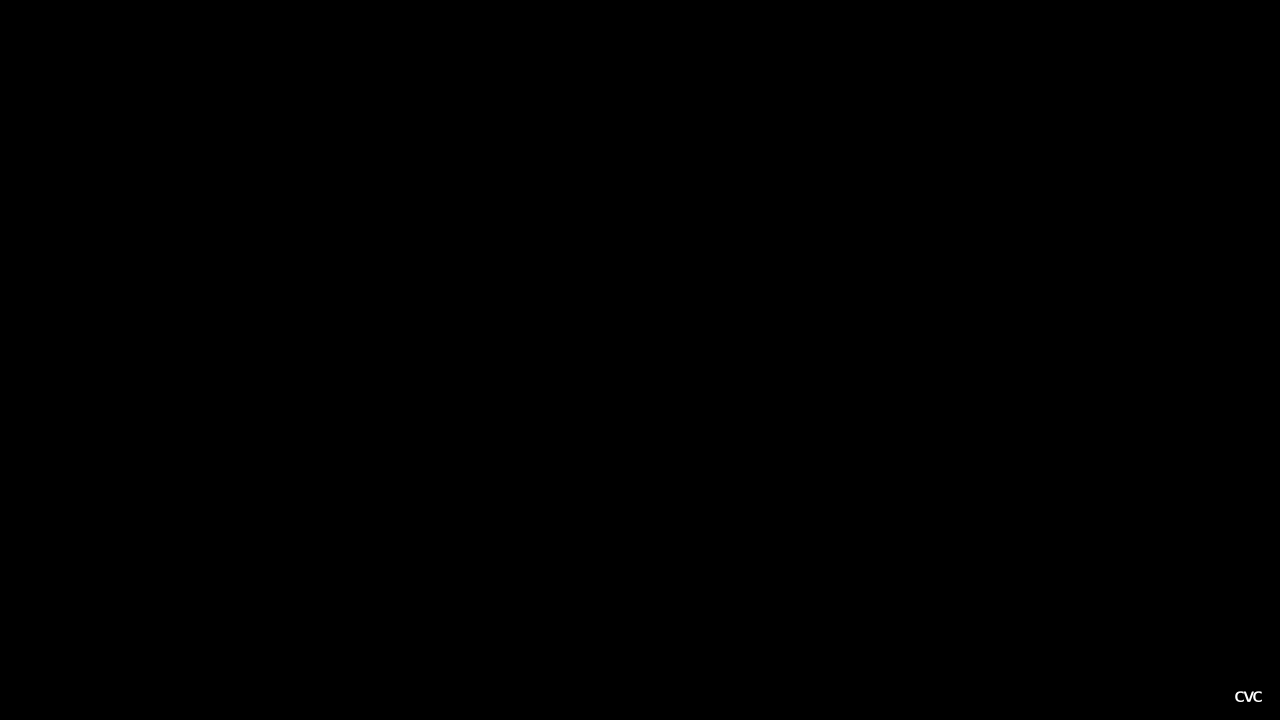

In [3]:
%%capture_video --path "animations/center_of_mass_force/scattering.mp4"
%%manim -qm --fps 20 $video_scene

class comf_Scene(Scene):
    def construct(self):
        CVC = Text('CVC', font_size = 12, weight = BOLD, color = WHITE, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        self.add(CVC)

        # Parameter
        T = 10
        dt = 0.01